# Recommendations with articles' interaction data from IBM Watson Studio

This notebook, explores reccomendation tecniques on real data from the IBM Watson Studio platform. 


## Table of Contents

I.      [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II.     [Rank Based Recommendations](#Rank)<br>
III.    [User-User Based Collaborative Filtering](#User-User)<br>
IV.     [Matrix Factorization](#Matrix-Fact)<br>
V.      [Conclusions](#Conclusion)<br>
VI.     [Future Developments](#Extra-Content)


## Importing Modules

In [907]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
pd.set_option('display.max_colwidth', 800)
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [908]:
# Show df_content to get an idea of the data
df_content.head(1)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next video is starting stop 1. Loading...\r\n\r\nWatch Queue Queue __count__/__total__ Find out why CloseDEMO: DETECT MALFUNCTIONING IOT SENSORS WITH STREAMING ANALYTICS\r\nIBM AnalyticsLoading...\r\n\r\nUnsubscribe from IBM Analytics? Cancel UnsubscribeWorking...\r\n\r\nSubscribe Subscribed Unsubscribe 26KLoading...\r\n\r\nLoading...\r\n\r\nWorking...\r\n\r\nAdd toWANT TO WATCH THIS AGAIN LATER?\r\nSign in to add this video to a playlist. Sign in Share More * ReportNEED TO REPORT THE VIDEO?\r\n Sign in to report inappropriate content. Sign in\r\n * Transcript\r\n * Statistics\r\n * Add translati...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>



`1.` What is the distribution of how many articles a user interacts with in the dataset? Utilizing visuals and descriptive statistics can effectively illustrate the frequency of user interactions with each article.  

<p> Since each unique email generates a unique has code, this makes the has code a reliable unique identifier making it functionally equivalent to a user ID.</p>

In [909]:
user_article_distribution = df.groupby('email')['article_id'].count().sort_values(ascending=False)


In [910]:
user_article_distribution.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

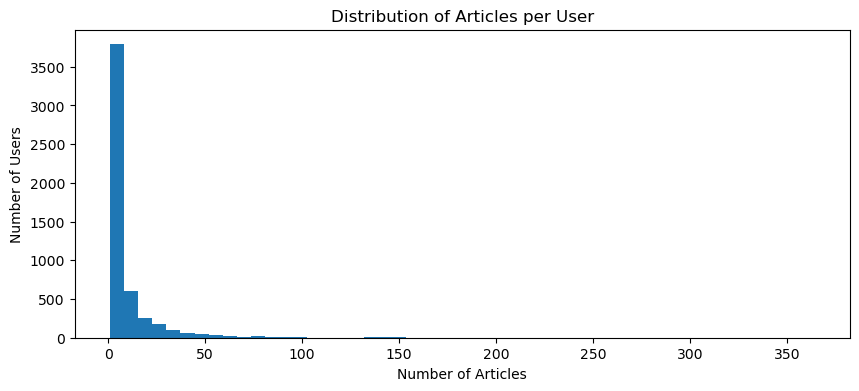

In [911]:
# Create histogram
plt.figure(figsize=(10, 4))
plt.hist(user_article_distribution, bins=50)
plt.title('Distribution of Articles per User')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users')
plt.show()

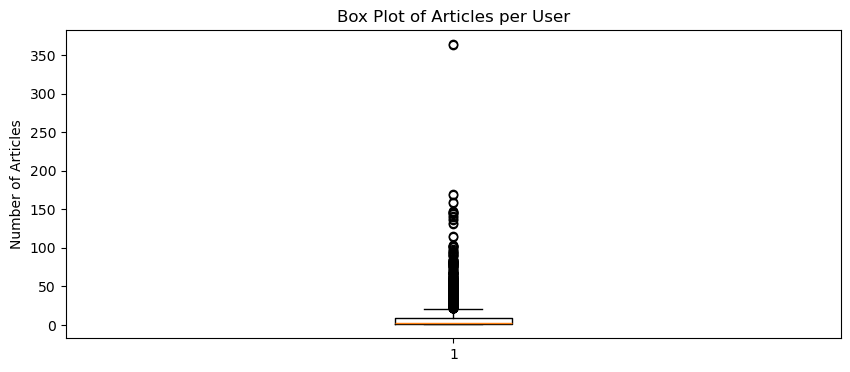

In [912]:
# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(user_article_distribution)
plt.title('Box Plot of Articles per User')
plt.ylabel('Number of Articles')
plt.show()

<p> Both visualizations show that the user article distribution is right skewed and might present some outliers </p>

In [913]:
# Fill in the median and maximum number of user_article interactios below

median_val = int(user_article_distribution.describe().iloc[5])# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = int(user_article_distribution.describe().iloc[7])# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [914]:
# Find and explore duplicate articles
number_duplicated_articles = df_content.article_id.duplicated().sum()

In [915]:
print(f"There are {number_duplicated_articles} duplicated articles in the df_content dataframe")

There are 5 duplicated articles in the df_content dataframe


In [916]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id',keep='first')


In [917]:
# checking the deduplication logic worked as expected
print(f"The are {df_content.article_id.duplicated().sum()} duplicated articles in the df_content dataframe")

The are 0 duplicated articles in the df_content dataframe


`3.` Let's find out more:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [918]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform/checked
unique_users = df.email.nunique()# The number of unique users/checked
user_article_interactions = df.shape[0]

`4.` Let's find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [919]:
most_viewed_article_id = df.article_id.value_counts(normalize=True,ascending=False).head(1).index[0].astype('str')# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts(ascending=False).head(1).iloc[0]# The most viewed article in the dataset was viewed how many times?
most_viewed_article_id,max_views
# results checked

('1429.0', 937)

In [920]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [921]:
## Testing results stored in the variable names above.


sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

So far we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below returns the **n** top articles ordered with most interactions as the top. 

In [922]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = df.title.value_counts(ascending=False).head(n).index
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.article_id.value_counts(ascending=False).head(n).index.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [923]:
#print(get_top_articles(10))
print(get_top_article_ids(10))

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [924]:
# Testing previous function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 



In [925]:
#creating the interaction field
df['interaction'] = 1
df.head()

,article_id,title,user_id,interaction
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [926]:
# create the user-article matrix with 1's and 0's


def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = pd.pivot_table(df,
                                   values='interaction',
                                   index='user_id',
                                   columns='article_id',
                                   fill_value=0, 
                                   aggfunc='max')  
    
    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

In [927]:
## Above code should pass tests with no changes
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 


In [929]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    provided_user = user_item.loc[user_id]
    dot_product = user_item.dot(provided_user)
    similarity_df = pd.DataFrame({
                    'user_id': dot_product.index,
                    'similarity': dot_product.values
                    })


    
    sorted_similarities = similarity_df.sort_values('similarity', ascending=False)

    most_similar_users = sorted_similarities[sorted_similarities['user_id'] != user_id]

       
    return most_similar_users['user_id'].values # return a list of the users in order from most to least similar
        

In [930]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870 4201   46   49]
The 5 most similar users to user 3933 are: [   1 3782   23  203 4459]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Having the most similar users to each user, we can use them to find articles to recommend.

In [932]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_ids = [float(id_) for id_ in article_ids] 
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    if len(article_names) > 0:
        return article_names
    else:
        return "The list provided returns no values"


    

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (float) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the article ids
    '''
    
    # Check if user exists in the index
    if user_id not in user_item.index:
        return [], []
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.tolist()[::-1]
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id, user_item=user_item)
    articles_seen = np.where(user_item[user_item.index==user_id]>0)[1].tolist()
    

    recs = set()
    for user in similar_users:
        if len(recs)>= m:
            break
        other_user_article_seen = np.where(user_item[user_item.index==user]>0)[1].tolist()
        new_recs = set(other_user_article_seen) - set(articles_seen)
        recs.update(new_recs)
    
    return list(recs)[:10] # return your recommendations for this user_id    

In [933]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['learn about data science in world of watson',
 'data science bowl 2017',
 'the art of side effects: curing apache spark streaming’s amnesia (part 1/2)']

In [934]:
get_article_names(['1024.0','1176'])#user_user_recs('1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'))

['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service']

In [935]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Next step is to improve the consistency of the **user_user_recs** function defined above.  

* Instead of arbitrarily choosing when to obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we can choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [936]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    neighbors_df - (pandas dataframe) containing:
        - neighbor_id: user ids of neighbors
        - similarity: dot product similarity score
        - num_interactions: number of articles viewed by each user
    '''
    
    user_id = float(user_id)
    user_articles = user_item.loc[user_id]
    
    # Calculate similarity with all other users
    similarities = user_item.dot(user_articles)
    
    num_interactions = user_item.sum(axis=1)
  
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': similarities,
        'num_interactions': num_interactions
    })
    
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], 
                                          ascending=[False, False])
    
    return neighbors_df

In [937]:


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
   
    user_id = float(user_id)
    user_articles, _ = get_user_articles(user_id)
    
    similar_users_df = get_top_sorted_users(user_id)
    
    recs = []
    
    # Loop through similar users until we have m recommendations
    for _, user_row in similar_users_df.iterrows():
        if len(recs) >= m:
            break
            
        neighbor_id = user_row['neighbor_id']
      
        neighbor_articles, _ = get_user_articles(neighbor_id)
        
        # Find articles the input user hasn't seen
        new_articles = list(set(neighbor_articles) - set(user_articles))
        
        # Add new articles to recommendations
        for article_id in new_articles:
            if article_id not in recs:
                recs.append(article_id)
            if len(recs) >= m:
                break
    
    
    rec_names = get_article_names(recs[:m])
    
    return recs[:m], rec_names

In [938]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1314.0', '415.0', '761.0', '990.0', '1422.0', '1336.0', '51.0', '763.0', '390.0', '692.0']

The top 10 recommendations for user 20 are the following article names:
['learn basics about notebooks and apache spark', 'use r dataframes & ibm watson natural language understanding', 'this week in data science (january 10, 2017)', 'variational auto-encoder for "frey faces" using keras', '15 page tutorial for r', 'load data into rstudio for analysis in dsx', 'using machine learning to predict value of homes on airbnb', 'introducing ibm watson studio ', 'healthcare python streaming application demo', 'modern machine learning algorithms']


`5.` Using the functions from above to correctly fill in the solutions test dictionary below.  

In [939]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']
user131_10th_sim = get_top_sorted_users(131).iloc[10]['neighbor_id']

In [940]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` Given a new user, which of the above functions would you be able to use to make recommendations?


`Explanation`

For new users without any interaction history, implementing a popularity-based recommendation approach is most effective. This strategy leverages the collective wisdom of the existing user base by recommending articles that have proven popular across the platform.

**Key Benefits:**
- Provides immediate recommendations without requiring user history
- Leverages proven content that has resonated with the broader user base
- Can be implemented using the existing `get_top_article_ids` function

**Implementation:**
The `get_top_article_ids` function serves as an ideal solution for new user recommendations since it:
- Ranks articles based on total user interactions
- Doesn't require individual user data
- Delivers consistently relevant content

This approach serves as an effective starting point until enough user interaction data is collected to enable more personalized recommendations.

**Provide your response here.**

`7.` Using existing functions, let's provide the top 10 recommended articles for the a new user below.  We can test the new approach below.

In [941]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)


In [942]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we focus on building use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

 

In [944]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [945]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Using Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix and explaining the differences with other user-item matrices observed in previous scenarios.

In [946]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

`Explanation.` The user_item_matrix presented in the above cell has bianary values (0,1) unlike the user_movie_subset matrix which has numerical ratings.


![Old-Matrix](previous_matrix.png)

`3.` How do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Runnig the cell below provides an idea of how the accuracy improves as we increase the number of latent features.

/opt/anaconda3/envs/DataScience/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


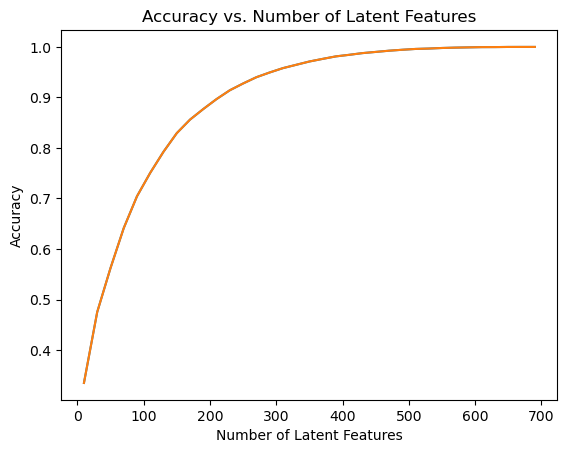

In [950]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.show();

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Using the function `create_user_item_matrix`, we can understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [951]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [952]:
len(create_test_and_train_user_item(df_train, df_test)[2]),len(create_test_and_train_user_item(df_train, df_test)[3])
len(test_idx)-20

662

In [953]:

train_idx = user_item_train.index.tolist()  
test_idx = user_item_test.index.tolist() 

common_users = set(train_idx).intersection(set(test_idx))

# Number of users 
num_predictable_users = len(common_users)

print(f"Number of users we can make predictions for: {num_predictable_users}")


Number of users we can make predictions for: 20


In [954]:
print(f"The number of users in the test set that we are not able to make prediction for because of the coldstart problem is {len(test_idx) - num_predictable_users}") #np.count_nonzero(user_item_test.values)

The number of users in the test set that we are not able to make prediction for because of the coldstart problem is 662


In [955]:

train_articles = user_item_train.columns.tolist()  
test_articles = user_item_test.columns.tolist()    


common_articles = set(train_articles).intersection(set(test_articles))

# Number of articles 
num_predictable_articles = len(common_articles)

print(f"Number of articles we can make predictions for: {num_predictable_articles}")


Number of articles we can make predictions for: 574


In [956]:
print(f"The number of articles in the test set that we are not able to make prediction for because of the coldstart problem is {len(test_articles) - num_predictable_articles}")

The number of articles in the test set that we are not able to make prediction for because of the coldstart problem is 0


In [957]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Using the  **user_item_train** dataset we find U, S, and V transpose using SVD; then the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This combines the work done in questions `2` - `4`.



In [958]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # use the built in to get the three matrices
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

We are going to consider users and articles that exist in both `user_item_train` and `user_item_test` to ensure that predictions can be made on comparable data.
- For a new user: There are no learned latent features for them (no row in u_train corresponds to this user).
- For a new article: There are no learned latent features for the article (no column in vt_train corresponds to this article).

In [959]:

#Filter user_item_test to only include rows and columns that can be predicted
user_item_test_common = user_item_test.loc[list(common_users), list(common_articles)]

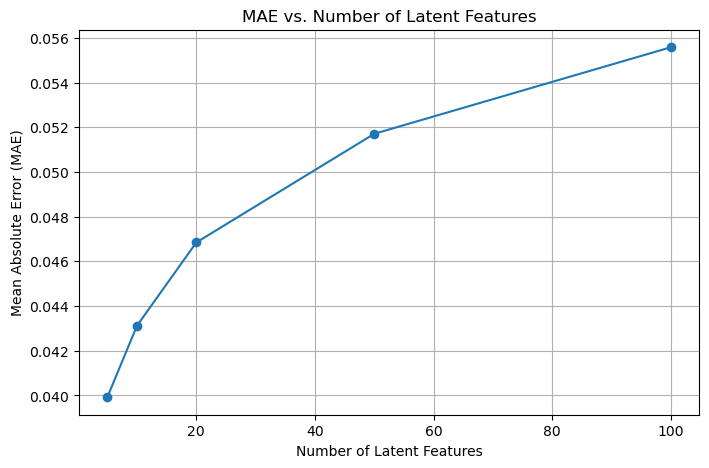

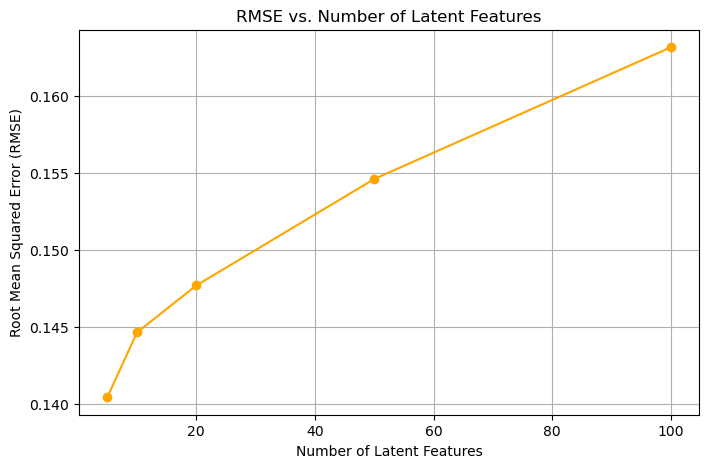

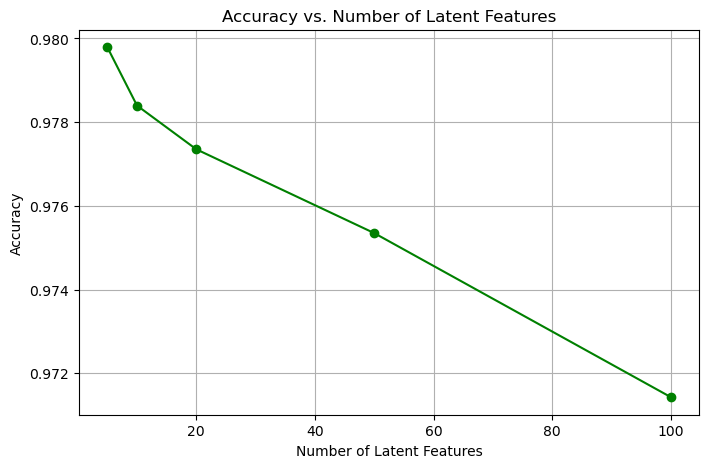

Latent Features: 5, MAE: 0.0399, RMSE: 0.1404, Accuracy: 0.9798
Latent Features: 10, MAE: 0.0431, RMSE: 0.1446, Accuracy: 0.9784
Latent Features: 20, MAE: 0.0468, RMSE: 0.1477, Accuracy: 0.9774
Latent Features: 50, MAE: 0.0517, RMSE: 0.1546, Accuracy: 0.9753
Latent Features: 100, MAE: 0.0556, RMSE: 0.1631, Accuracy: 0.9714


In [960]:
# diagonal matrix
s_train_diag = np.diag(s_train)

latent_features = [5, 10, 20, 50, 100]  
accuracies = []
mae_values = []
rmse_values = []
common_articles = list(common_articles)
common_users = list(common_users)

for k in latent_features:
    # Reduce U, S, and Vt to k latent features
    u_train_k = u_train[:, :k]
    s_train_k = s_train_diag[:k, :k]
    vt_train_k = vt_train[:k, :]

    
    user_item_train_reconstructed = np.dot(np.dot(u_train_k, s_train_k), vt_train_k)

    # reconstructed matrix with the test set
    preds_df = pd.DataFrame(user_item_train_reconstructed, index=user_item_train.index, columns=user_item_train.columns)
    preds_common = preds_df.loc[common_users, common_articles]

    
    test_actual = user_item_test_common.loc[common_users, common_articles].values

    
    preds = preds_common.values

    # Calculate Mean Absolute Error (MAE)
    diffs = test_actual - preds
    mae = np.mean(np.abs(diffs))
    mae_values.append(mae)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean(diffs ** 2))
    rmse_values.append(rmse)

    # Binary classification: interaction or no interaction
    preds_binary = np.where(preds >= 0.5, 1, 0)

    # Calculate accuracy
    accuracy = np.mean(preds_binary == test_actual)
    accuracies.append(accuracy)

# Plot MAE vs. Number of Latent Features
plt.figure(figsize=(8, 5))
plt.plot(latent_features, mae_values, marker='o', linestyle='-')
plt.xlabel('Number of Latent Features')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Number of Latent Features')
plt.grid(True)
plt.show()

# Plot RMSE vs. Number of Latent Features
plt.figure(figsize=(8, 5))
plt.plot(latent_features, rmse_values, marker='o', color='orange', linestyle='-')
plt.xlabel('Number of Latent Features')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs. Number of Latent Features')
plt.grid(True)
plt.show()

# Plot Accuracy vs. Number of Latent Features
plt.figure(figsize=(8, 5))
plt.plot(latent_features, accuracies, marker='o', color='green', linestyle='-')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.grid(True)
plt.show()


for k, mae, rmse, acc in zip(latent_features, mae_values, rmse_values, accuracies):
    print(f"Latent Features: {k}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, Accuracy: {acc:.4f}")

### <a class="anchor" id="Content-Recs">Part V: Conclusions</a>

#### Analysis of Latent Features and Model Performance

The results demonstrate how varying the number of latent features in the model impacts performance metrics—**Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, and **Accuracy**. As the number of latent features increases from 5 to 100, the following trends are observed:

- **MAE increases** from 0.0399 to 0.0556.
- **RMSE increases** from 0.1404 to 0.1631.
- **Accuracy decreases** from 0.9798 to 0.9714.

These patterns indicate that increasing the number of latent features leads to a slight decline in model performance.

#### Interpretation of Results

**Increasing MAE and RMSE** suggest that the model's predictions are becoming less accurate with more latent features. MAE measures the average magnitude of errors without considering their direction, providing a straightforward interpretation of prediction accuracy. RMSE, on the other hand, squares the errors before averaging, giving more weight to larger errors. The rise in both metrics implies that the model may be overfitting the training data as complexity increases.

**Decreasing Accuracy** further supports the possibility of overfitting. Overfitting occurs when a model learns the noise in the training data, reducing its ability to generalize to new data.

#### Possible Reasons and Recommendations

- **Overfitting Due to Increased Complexity**: More latent features can cause the model to capture noise rather than relevant patterns, leading to overfitting.
  
- **Optimal Latent Feature Selection**: The results suggest that a smaller number of latent features (e.g., 5 or 10) yields better performance. Selecting the appropriate number of features is crucial to balance bias and variance.

- **Implement Regularization**: Applying regularization techniques can mitigate overfitting when using a higher number of latent features.

#### <i>Conclusion</i>

In summary, **utilizing fewer latent features resulted in improved model performance**, as indicated by lower MAE and RMSE values and higher accuracy. It's essential to find the optimal number of latent features to ensure the model generalizes well to unseen data.

### <a class="anchor" id="Content-Recs">Part VI: Extra Content</a>

Below are additional development ideas to augment this project:

- Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  As a future development for this project, we can create a content based reccomender.
- After saving recommendations for each user, we could develop a class to make new predictions and update results, and make a flask app to deploy your results. 